# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - This data set has 1990 rows, 8 columns. I have validated all variables and I have not made any changes after validation. All the columns are just as described in the data dictionary:

 * clinic_id: Is a unique key to identify a row in dataset. can be dropped and not significant for our modeling. No cleaning is needed.
 * ownership: 4 unique values without missing values. There is typo and will require to be replaced with proper value. After replavce 3 unique values as described.
 * hospital_location: 3 unique values, there is a 3rd un expected value -. As there is no clear determination of any location or zip to determine these - values. it's ideal to drop them. But dropping 119 rows is also taking away crucial data from modeling.Had to choose frequent value to replace and all these 119 are replaced as Urban. 
 * admitted_patients: numeric values, without missing values, same as the description. No cleaning is needed.
 * nurse_patient_ratio : positive numeric values, same as the description. No cleaning is needed.
 * ed_visits: There are negative values, should be converted to positive using abs.
 * satisfaction_score: numeric values, with 159 missing values. Can be replaced by median as data is skewed.
 * revenue: positive numeric values without missing values, same as the description. No cleaning is needed.

- Final summary including recommendations that the business should undertake
*Model needs to be tuned and re run on larger data set to draw clear conclusions
Form what is observed here are the conclusion and recommendations
1) Features Total viists, specificially ed_visits contribute at large to revenue and also patient satisfaction *
2) data should have projected the hospital location and nurse patient ratio better to draw any conclusion of implication of these features to revenue 
3) ownership seems to have very little to no impact on revenue generation which is more practically valid to real world scneario. 
4) More features such as
  i)   Doctor patient ratio
  ii)  in-patient to out-patient ratio
  iii) satisfaction ratio with respect to in-patient and out-patient. 
  iv)  Patient wait time on each visit. 
  v)   date or season of visit.
  These attributes greatly contribute to revenue and satisfaction ratio. having these features gives more dataset to understand and project the revenue. 
5) Major constraint with data has been it's limited nature of complexity and volumn. Models generated must be run on larger data volumn and then implemented into real business projections. while this models go through several more iterations and validations would require corresponding adjustment to parameters and base models. 

In [82]:
# Loading Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# To build model for prediction
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn import tree

# To tune different models
#from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, PowerTransformer, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)

In [83]:
# Load file into DataFrames
health_revenue = pd.read_csv('health_revenue.csv')

In [84]:
# Data Validation
health_revenue.shape

(1990, 8)

In [85]:
health_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990 entries, 0 to 1989
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   clinic_id            1990 non-null   int64  
 1   ownership            1990 non-null   object 
 2   hospital_location    1990 non-null   object 
 3   admitted_patients    1990 non-null   int64  
 4   nurse_patient_ratio  1990 non-null   float64
 5   ed_visits            1990 non-null   int64  
 6   satisfaction_score   1831 non-null   float64
 7   revenue              1990 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 124.5+ KB


There are 8 columns as seen in the above information. all dtypes are properly defined as per data in them

In [86]:
print ("Null's in Health Revenue dataset")
health_revenue.isna().sum()

Null's in Health Revenue dataset


clinic_id                0
ownership                0
hospital_location        0
admitted_patients        0
nurse_patient_ratio      0
ed_visits                0
satisfaction_score     159
revenue                  0
dtype: int64

There are nulls observed in satisfaction_score, which is understandable considering it's choice of patient to provide the feedback and not a mandatory field. These nulls can be replaced with mean/mode based on how is the distribution. 

In [87]:
health_revenue.head()

clinic_id   ownership  ... satisfaction_score    revenue
0       1847      Profit  ...               2.04   55684.18
1        422      Profit  ...               2.77  117115.85
2       1843      Public  ...               3.13   72794.56
3         14  Non-Profit  ...               1.30   87447.23
4       1880      Public  ...               5.90   88848.01

[5 rows x 8 columns]

In [88]:
health_revenue['ownership'].value_counts(dropna=False)

Profit         987
Public         566
Non-Profit     398
non_profitt     39
Name: ownership, dtype: int64

ownsership has a misspelled label and will be corrected through below steps. 

In [89]:
health_revenue['ownership'] = health_revenue['ownership'].replace(['non_profitt'], 'Non-Profit')

In [90]:
health_revenue['ownership'].value_counts(dropna=False)

Profit        987
Public        566
Non-Profit    437
Name: ownership, dtype: int64

In [91]:
health_revenue['hospital_location'].value_counts(dropna=False)


Urban    1109
Rural     762
-         119
Name: hospital_location, dtype: int64

Hospital location seems to be missing labels, will see how much of the data is this and if removing or replacing them will make sense

In [92]:
(health_revenue['nurse_patient_ratio'].values <= 0).any()

True

There are 0 values in nurse patient ratio. these will be replaced with mean values later during the modeling. Choose mean as there is skewing in the data.

In [93]:
(health_revenue['ed_visits'].values <= 0).any()

True

ed_visits seems to have negative values which is not expected. these should be converted to positive and is done so using below steps

In [94]:
health_revenue['ed_visits'] = health_revenue['ed_visits'].abs()

In [95]:
(health_revenue['ed_visits'].values <= 0).any()

False

Any more nulls/missing values: False


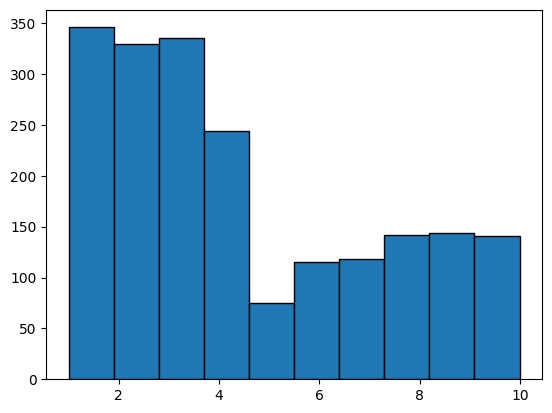

In [96]:
# Replace missing values with Medians
health_revenue['satisfaction_score'] = health_revenue['satisfaction_score'].fillna(health_revenue['satisfaction_score'].mean()) 
print("Any more nulls/missing values:",health_revenue['satisfaction_score'].isnull().any())

plt.hist( health_revenue['satisfaction_score'], edgecolor = "black")
plt.show() 

In [97]:
(health_revenue['revenue'].values <= 0).any() 

False

Revenue doesn't have nay nulls or negative values. which is expected.

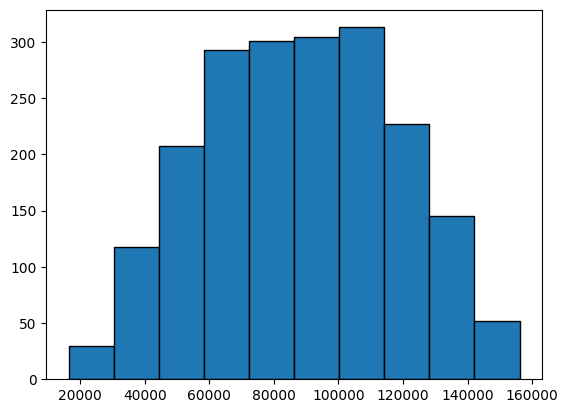

In [98]:
# Revenue data is already normalized distribution
plt.hist(health_revenue['revenue'],edgecolor = "black")
plt.show() 

Revenue seems to be almost regularly distributed.

In [99]:
#replace the dash with a NaN and impute
health_revenue.hospital_location.replace('-', np.nan, inplace = True)

In [100]:
#Impute the missing locations using the mode
health_revenue['hospital_location'] = health_revenue['hospital_location'].fillna(health_revenue['hospital_location'].mode()[0])

In [101]:
health_revenue.hospital_location.value_counts()

Urban    1228
Rural     762
Name: hospital_location, dtype: int64

Hostpital lcoations with - values are now replaced with mode/frequent values and we can see all 119 - are now replace to Urban

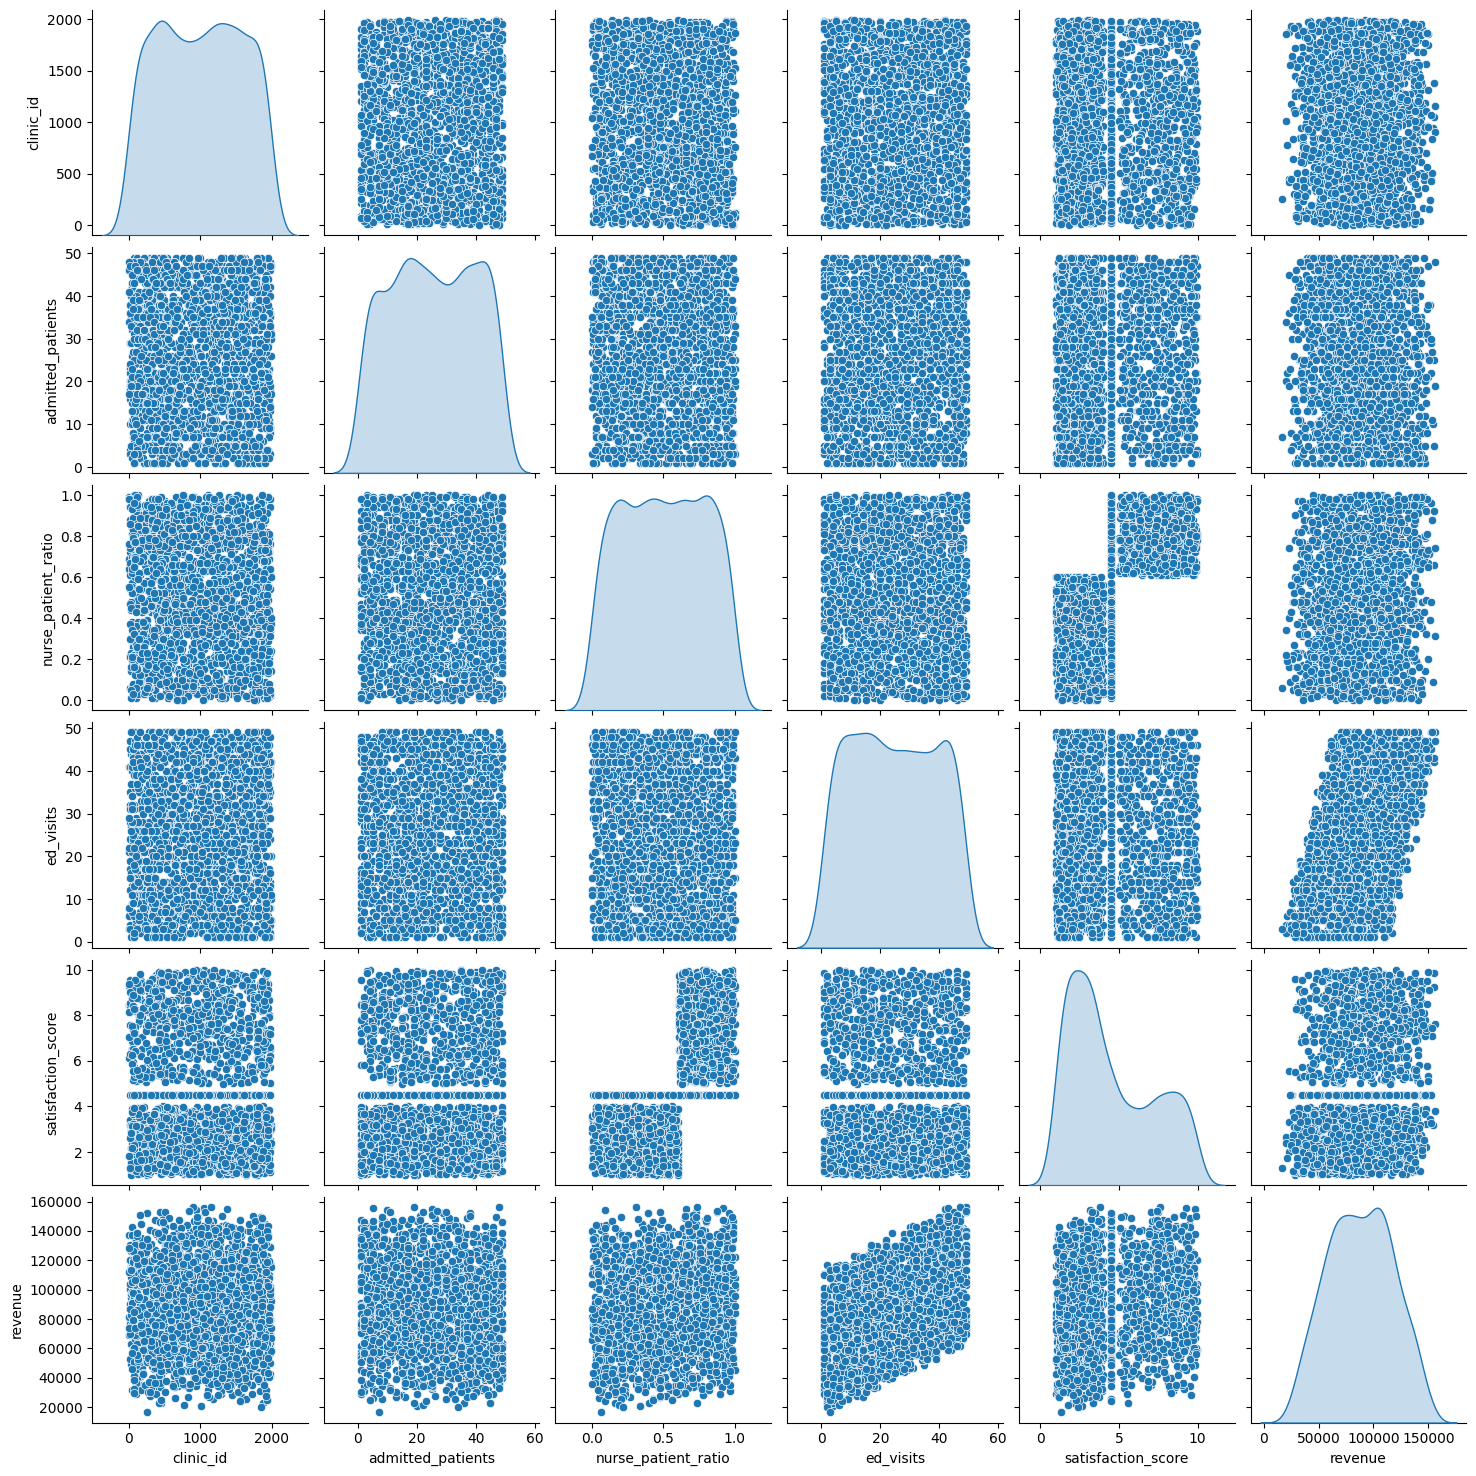

In [102]:
sns.pairplot(data=health_revenue, diag_kind="kde")

Don't see any linearity in the data set. but can see a little pattern with ed_Visits and satisfaction score with revenue.
Few reasons for it
1) volumn of data. 
2) instead of ed_visits and admitted patient. There should be a feature for total patients. currently it's had to interpret admitted_patients+ ed_visits is total patients as part of admitted_patients would be ed_visits.
3) assuming nurse ratio provided is based on total visits. it's ideal to try considering total visits as admitted patients + ed_visits. 
4) step 3 would also with converting nurse patient ratio to a whole number that is total nurses. 
5) hospital lcoation should have been a critical part of data which contributes to revenu but doesn't seem to be true with data analysis. 
6) suprisingly satisfactory score as little implication on revenue gain/loss. Also, nurse patient ratio has contributed little to satisfaction score. 

In [103]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

Above is functions to generate box plot and histograms for features. This will save time in generating the required charts

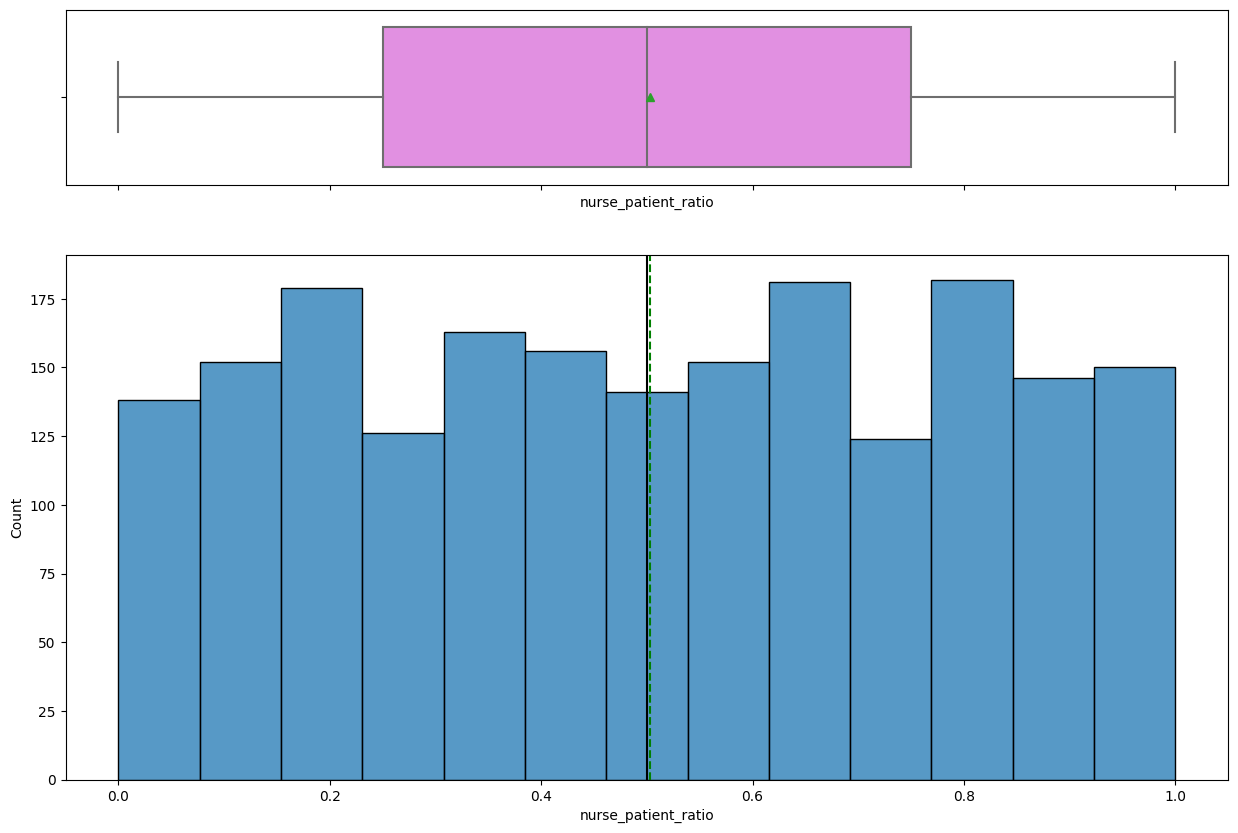

In [104]:
histogram_boxplot(health_revenue, "nurse_patient_ratio")

There are no outliers but we do see lot of variance on nurse patient ratio. Ratio is distributed between 0 - 1. we can apply log on this to make it more uniform. 

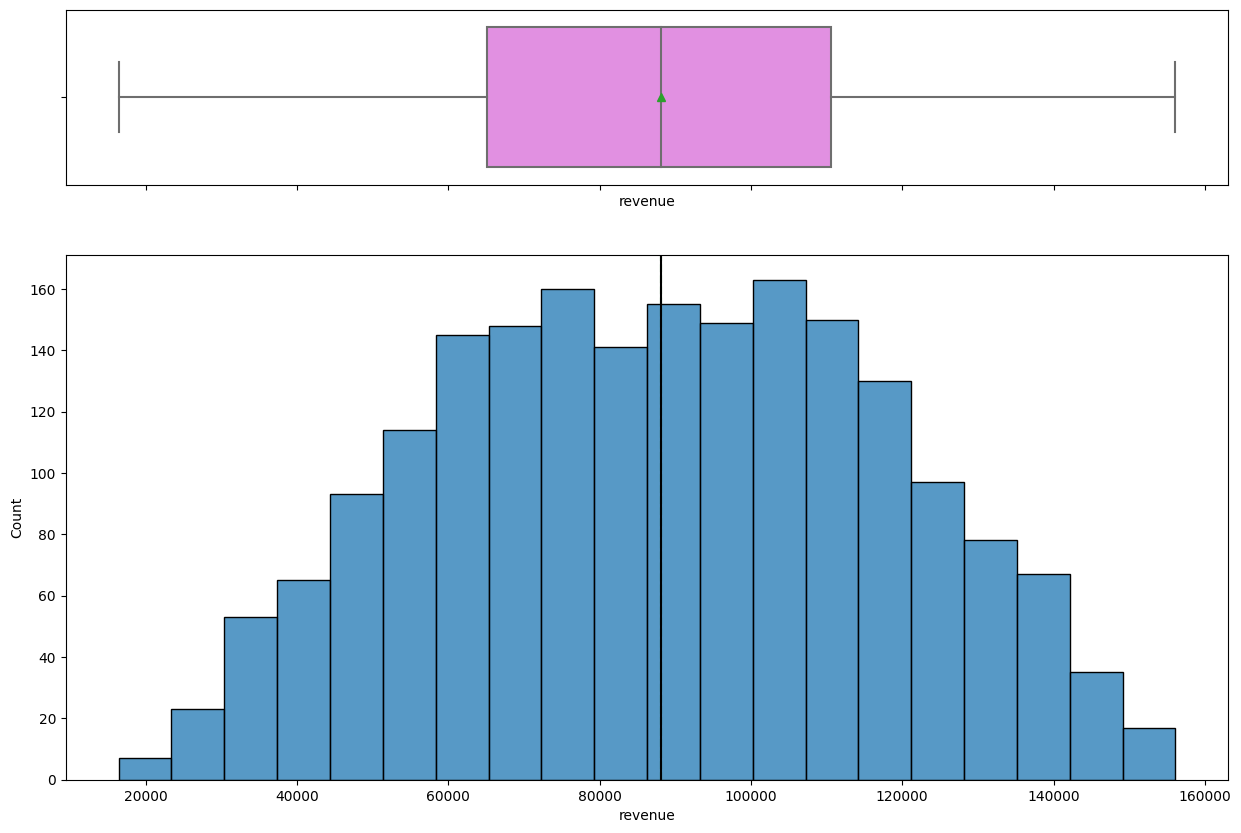

In [105]:
histogram_boxplot(health_revenue, "revenue")

Revenue as discussed earlier is looking pretty uniformly distributed. 

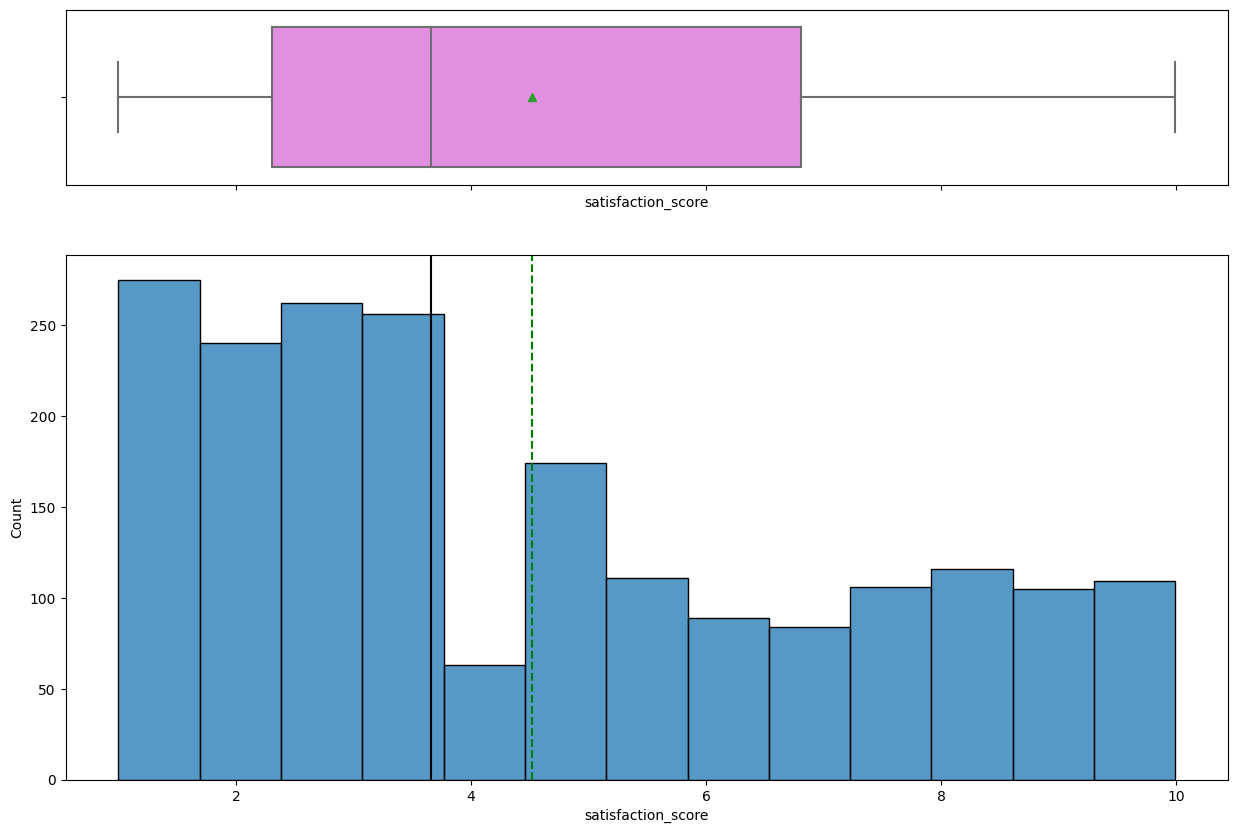

In [106]:
histogram_boxplot(health_revenue, "satisfaction_score")

Satisfaction_score are sckewed idicating most of the review falling lower than 5. implicating two reasons 1) we don't have enough data to reach a conclusion 2) most of the patients not participating in survey and those participating are mostly not satisfied.

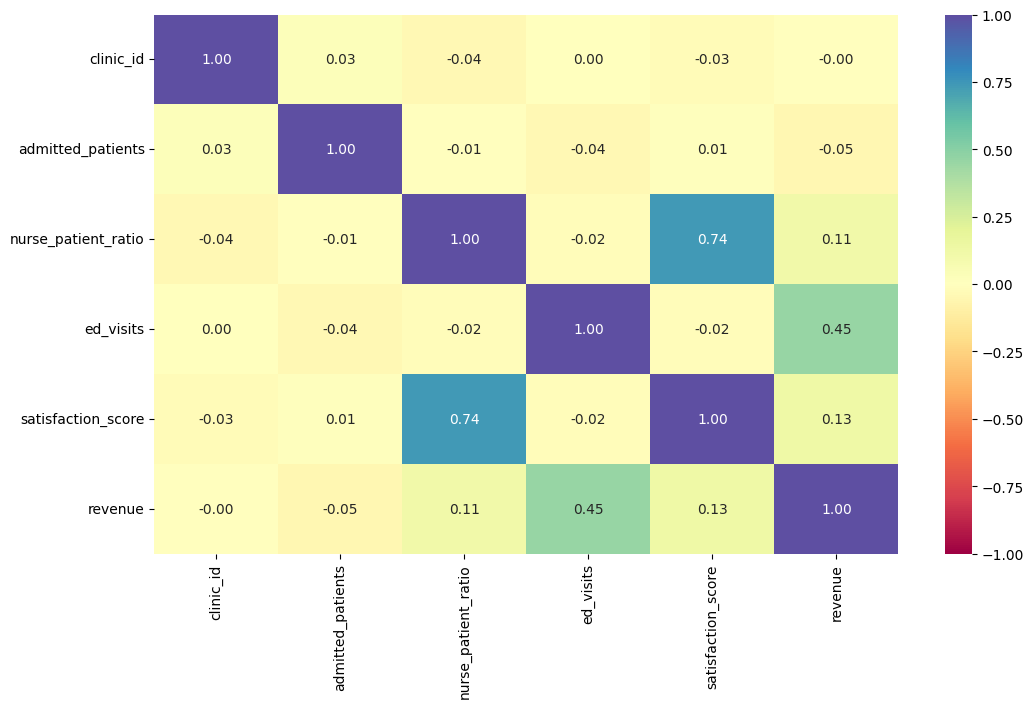

In [107]:
cols_list = health_revenue.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(12, 7))
sns.heatmap(
    health_revenue[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()


Admitted patients and clinic id have least corelation implying least impact on revnue preditction and safely dropped through the modeling.
ed_visits has highest correlation with revenue followed by satisfaction score and nurse patient ratio. Let's see how these will span as we proceed with modeling and feature engineering.

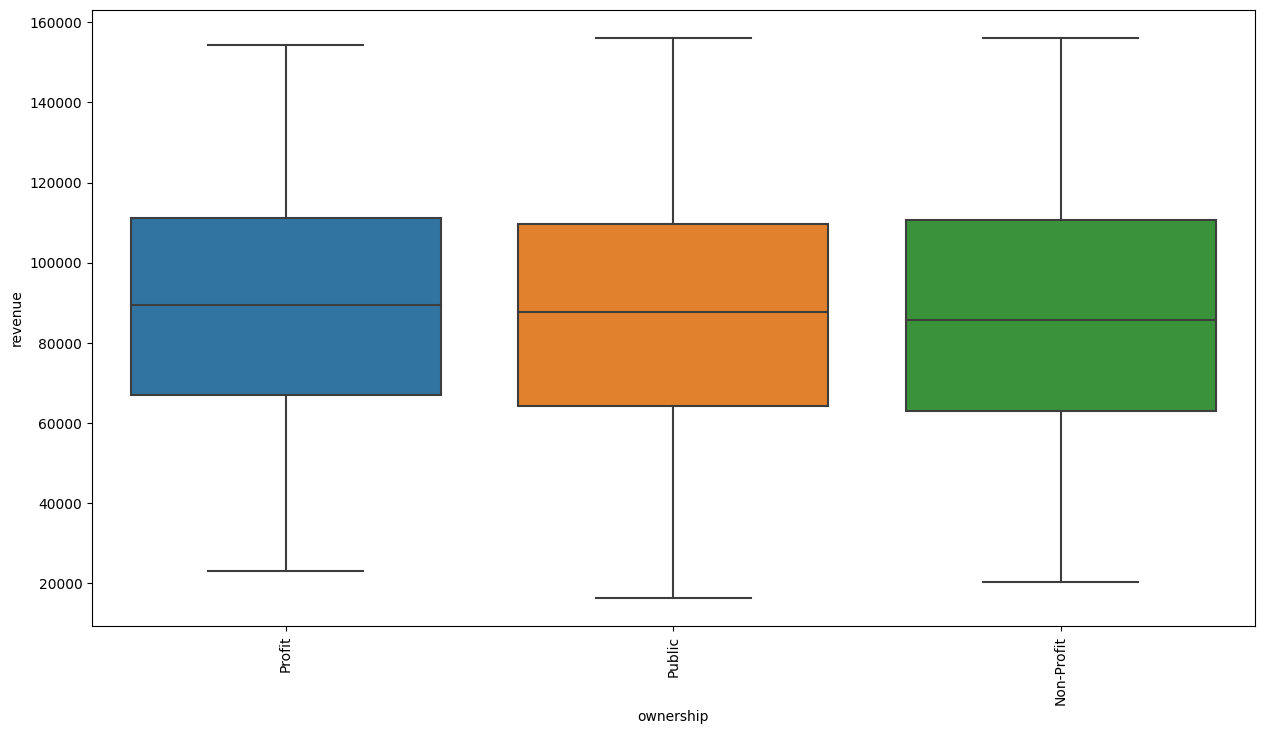

In [108]:
plt.figure(figsize=(15,8))
sns.boxplot(data=health_revenue, x='ownership', y='revenue')
plt.xticks(rotation=90);

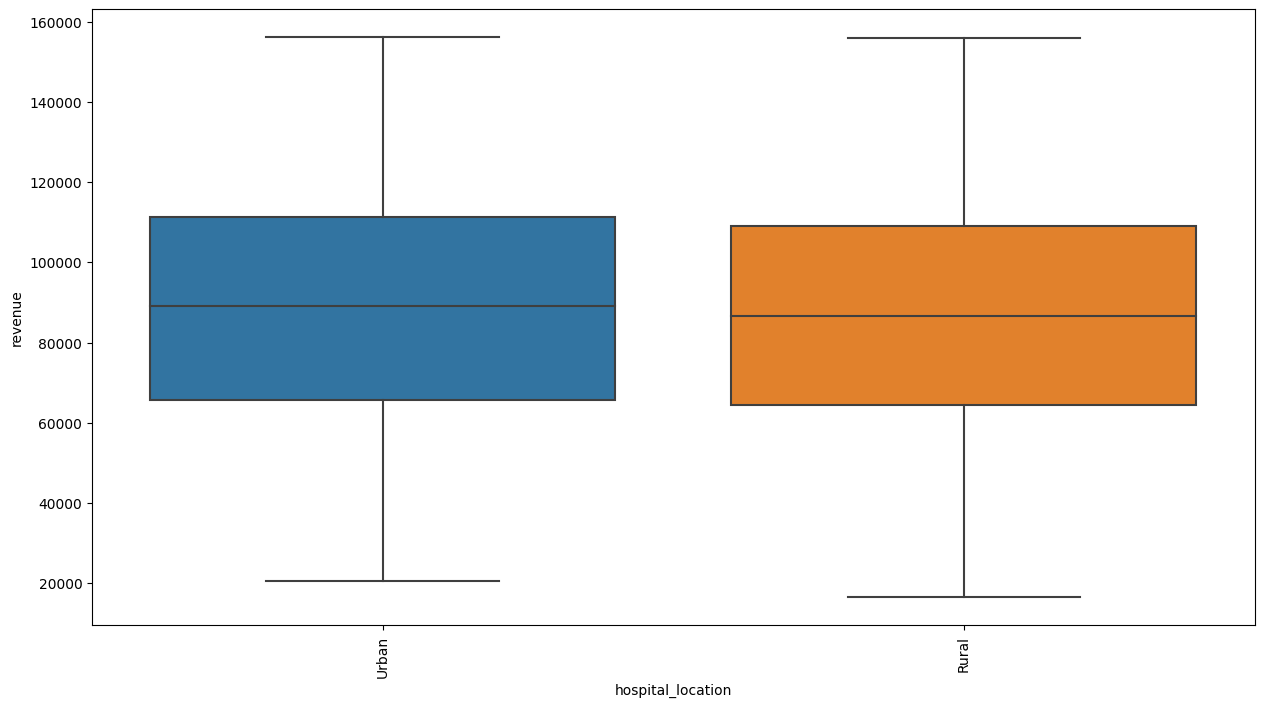

In [109]:
plt.figure(figsize=(15,8))
sns.boxplot(data=health_revenue, x='hospital_location', y='revenue')
plt.xticks(rotation=90);

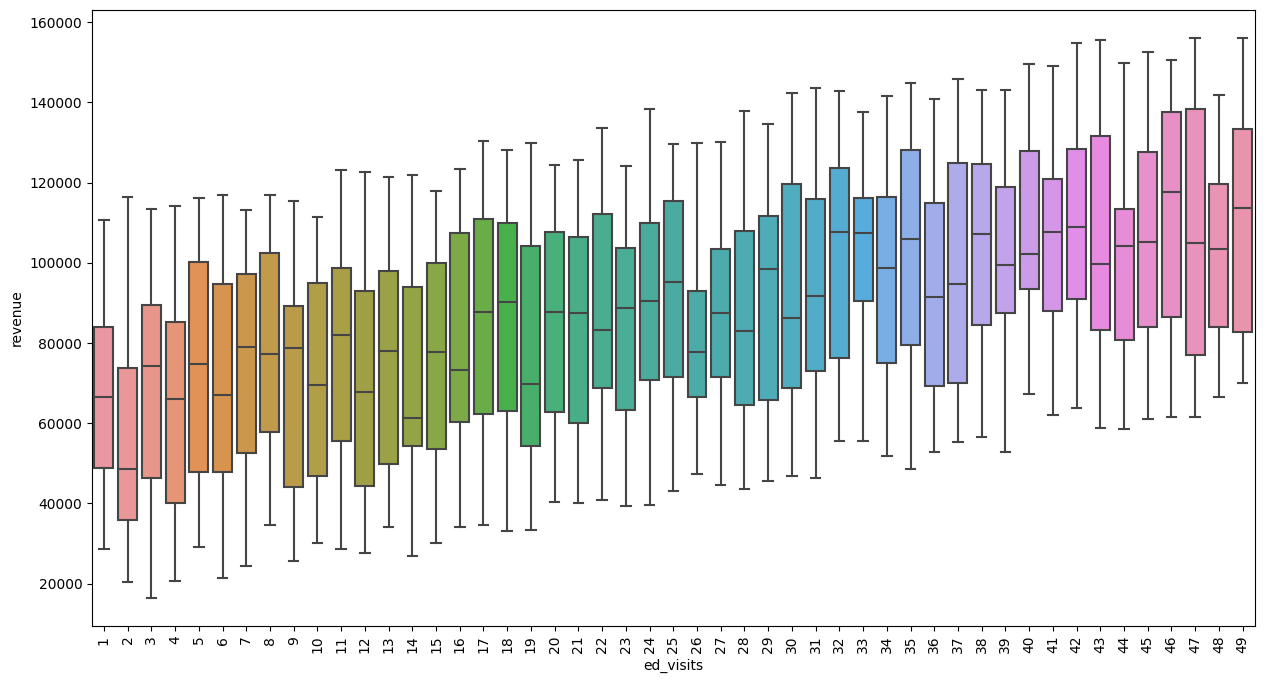

In [110]:
plt.figure(figsize=(15,8))
sns.boxplot(data=health_revenue, x='ed_visits', y='revenue')
plt.xticks(rotation=90);

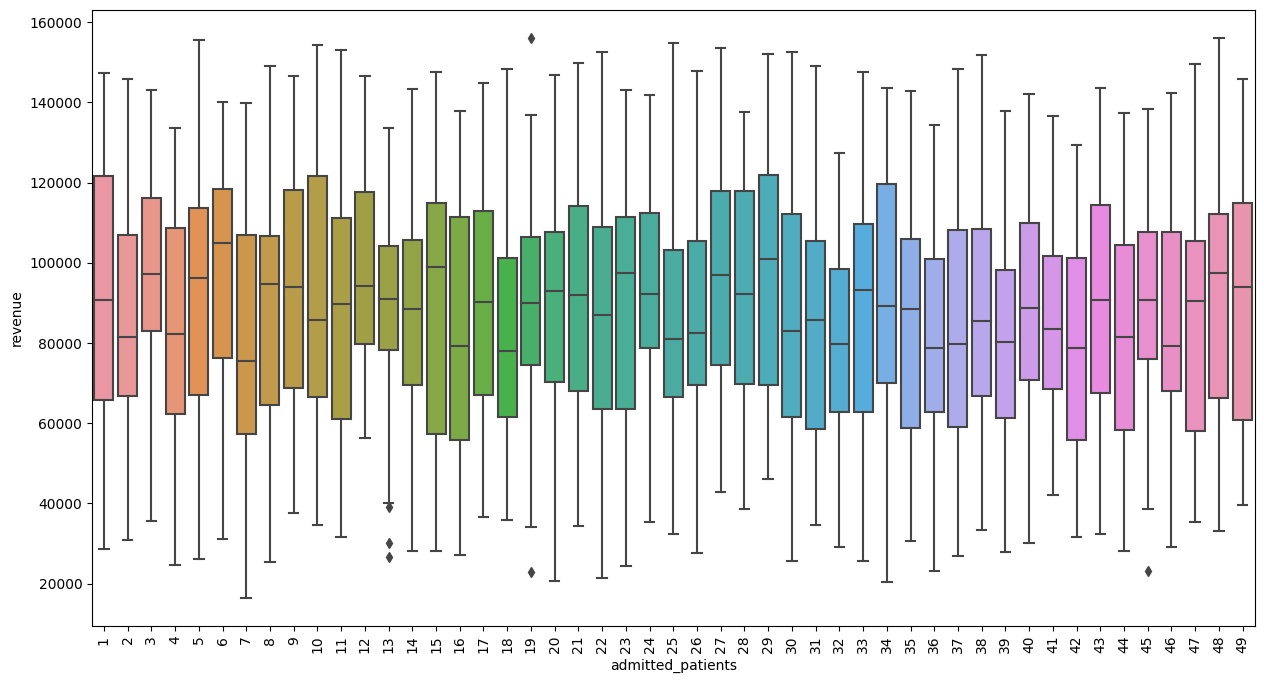

In [111]:
plt.figure(figsize=(15,8))
sns.boxplot(data=health_revenue, x='admitted_patients', y='revenue')
plt.xticks(rotation=90);

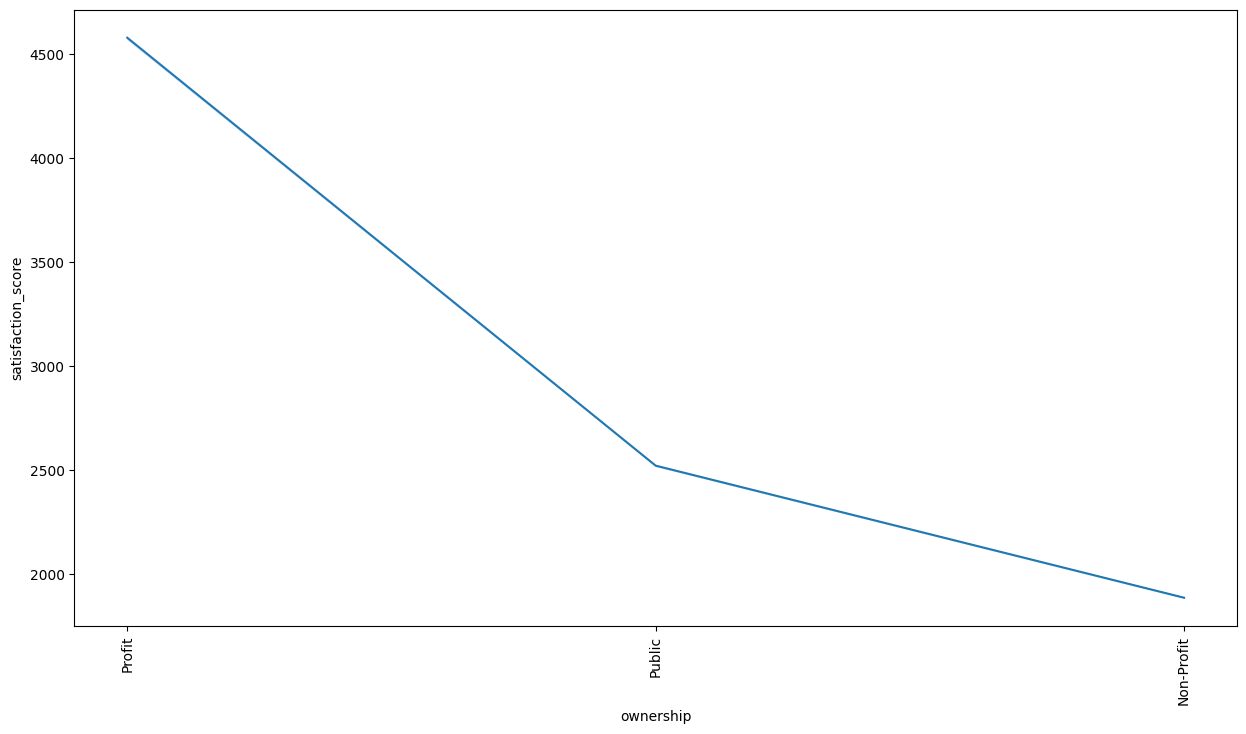

In [112]:
plt.figure(figsize=(15,8))
sns.lineplot(data=health_revenue, x='ownership', y='satisfaction_score', ci=False, estimator='sum')
plt.xticks(rotation=90);

In [113]:
health_revenue.groupby('ownership')['satisfaction_score','revenue'].mean()

satisfaction_score       revenue
ownership                                   
Non-Profit            4.315938  86625.267712
Profit                4.638875  88944.809656
Public                4.454146  87684.470283

Hospital ownership has zero to no impact on satisfactor score and revenue. All the means seems to be be on same range of ~4, revenue spanning ~86K

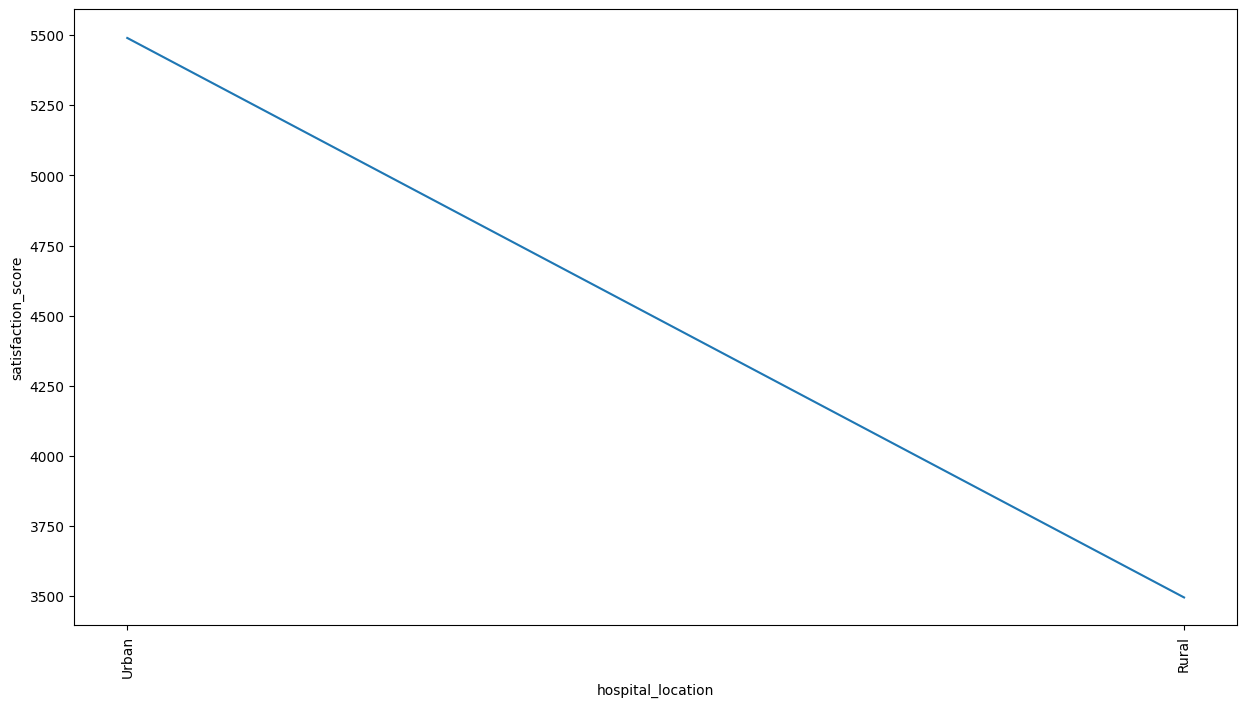

In [114]:
plt.figure(figsize=(15,8))
sns.lineplot(data=health_revenue, x='hospital_location', y='satisfaction_score', ci=False, estimator='sum')
plt.xticks(rotation=90);

In [115]:
health_revenue.groupby('hospital_location')['satisfaction_score','revenue'].mean()

satisfaction_score       revenue
hospital_location                                  
Rural                        4.587100  87039.249226
Urban                        4.470937  88720.905041

Hospital location ownership has zero to no impact on satisfactor score and revenue. All the means seems to be be on same range of ~4, revenue spanning ~87K

In [116]:
health_revenue_new=health_revenue

In [117]:
health_revenue_new.head()

clinic_id   ownership  ... satisfaction_score    revenue
0       1847      Profit  ...               2.04   55684.18
1        422      Profit  ...               2.77  117115.85
2       1843      Public  ...               3.13   72794.56
3         14  Non-Profit  ...               1.30   87447.23
4       1880      Public  ...               5.90   88848.01

[5 rows x 8 columns]

In [118]:
health_revenue_new = health_revenue_new.drop("clinic_id", axis=1)

In [119]:
health_revenue_new=pd.get_dummies(health_revenue_new,columns=["ownership"],drop_first=True)

In [120]:
health_revenue_new=pd.get_dummies(health_revenue_new,columns=["hospital_location"],drop_first=True)

Ownership and hospitals have labeled data which is not used for modeling and needs to be converted to binary variables. we will use dummies to convert this. 

In [121]:
health_revenue_new.head()

admitted_patients  ...  hospital_location_Urban
0                 23  ...                        1
1                 22  ...                        1
2                 47  ...                        0
3                 20  ...                        1
4                 33  ...                        0

[5 rows x 8 columns]

In [122]:
X = health_revenue_new.drop("revenue",axis=1) 
#X = health_revenue_new[feature_cols]
y = health_revenue_new["revenue"]

Data is now split into features and target into X and y variables respectively

In [123]:
X_train, X_test, y_train, y_test= train_test_split( X,y,test_size=0.25, random_state=42)
#X_train, X_test, y_train, y_test= train_test_split( X,y_transformed)

Splitting the data into train and test data. Volumn being low i was inclined to use 90% train and 10% test but model was not performing on test. 75/25 split has given better scores and will stick to this split ratio for further model process.

In [124]:
rfr = RandomForestRegressor()
# Set the number of trees
rfr.n_estimators = 50
# Add a maximum depth
rfr.max_depth = 5
# Set the random state
rfr.random_state = 1111
# Fit the model
rfr.fit(X_train, y_train)

print("Feature Importance:")
# Print how important each column is to the model
for i, item in enumerate(rfr.feature_importances_):
      # Use i and item to print out the feature importance of each column
    print("{0:s}: {1:.2f}".format(X_train.columns[i], item))

y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)

print("\nScores:")
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')
r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

Feature Importance:
admitted_patients: 0.07
nurse_patient_ratio: 0.09
ed_visits: 0.65
satisfaction_score: 0.17
ownership_Profit: 0.01
ownership_Public: 0.01
hospital_location_Urban: 0.01

Scores:
MAE train: 21104.70
MAE test: 22148.74
R^2 train: 0.32
R^2 test: 0.26


Have choose RandomforestRegressor, which would help me understand the feature importance and also help me eliminate the un impactful features easily. 

Let's drop ownership, hospital_location and check the scores.
Scores seemed almost same.
MAE train: 21119.96
MAE test: 22116.15
R^2 train: 0.32
R^2 test: 0.26

Let's try eliminating admitted_patients

In [125]:
# 'admitted_patients',nurse_patient_ratio','ed_visits','ownership','hospital_location','satisfaction_score','total_visits','number_of_nurses'
feature_cols = ['ed_visits','satisfaction_score','nurse_patient_ratio']


limiting the features to high impactful features.

In [126]:
#X_new = health_revenue_new.drop("revenue",axis=1) 
X_new = health_revenue_new[feature_cols]
y_new = health_revenue_new["revenue"]

In [127]:
X_train_new, X_test_new, y_train_new, y_test_new= train_test_split( X_new,y_new,test_size=0.25, random_state=42)
#X_train, X_test, y_train, y_test= train_test_split( X,y_transformed)

In [128]:
rfr_new = RandomForestRegressor()
# Set the number of trees
rfr.n_estimators = 50
# Add a maximum depth
rfr_new.max_depth = 5
# Set the random state
rfr_new.random_state = 1111
#set criterion
#rfr_new.criterion='squared_error'
# Fit the model
rfr_new.fit(X_train_new, y_train_new)

print("Feature Importance:")
# Print how important each column is to the model
for i, item in enumerate(rfr_new.feature_importances_):
      # Use i and item to print out the feature importance of each column
    print("{0:s}: {1:.2f}".format(X_train_new.columns[i], item))
    
y_train_pred = rfr_new.predict(X_train_new)
y_test_pred = rfr_new.predict(X_test_new)

print("\nScores:")
mae_train = mean_absolute_error(y_train_new, y_train_pred)
mae_test = mean_absolute_error(y_test_new, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')
r2_train = r2_score(y_train_new, y_train_pred)
r2_test =r2_score(y_test_new, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

Feature Importance:
ed_visits: 0.68
satisfaction_score: 0.21
nurse_patient_ratio: 0.11

Scores:
MAE train: 21199.79
MAE test: 22143.74
R^2 train: 0.31
R^2 test: 0.25


Even limiting the features to most important didn't make much of difference on the score. rather score dropped. 
But with just 3 predictors which is reasonable 

Let's try Linear Regressor to see how it performs. We are using OLS model to see basic coefficient and probability and r2.

In [129]:
olsmod=sm.OLS(y_train, X_train)
olsres = olsmod.fit()
print(olsres.summary())

                                 OLS Regression Results                                
Dep. Variable:                revenue   R-squared (uncentered):                   0.895
Model:                            OLS   Adj. R-squared (uncentered):              0.894
Method:                 Least Squares   F-statistic:                              1807.
Date:                Wed, 29 Nov 2023   Prob (F-statistic):                        0.00
Time:                        21:10:07   Log-Likelihood:                         -17499.
No. Observations:                1492   AIC:                                  3.501e+04
Df Residuals:                    1485   BIC:                                  3.505e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [130]:
olsmod=sm.OLS(y_train_new, X_train_new)
olsres = olsmod.fit()
print(olsres.summary())

                                 OLS Regression Results                                
Dep. Variable:                revenue   R-squared (uncentered):                   0.867
Model:                            OLS   Adj. R-squared (uncentered):              0.867
Method:                 Least Squares   F-statistic:                              3249.
Date:                Wed, 29 Nov 2023   Prob (F-statistic):                        0.00
Time:                        21:10:07   Log-Likelihood:                         -17672.
No. Observations:                1492   AIC:                                  3.535e+04
Df Residuals:                    1489   BIC:                                  3.537e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

Coefficients seems to be very high and probabilities are 0 on certain features, implying strong dependency of these to revenue and further analysis is recommended.R2 is high enough to determine that all the features in model define the target appropriately.

Creating new features from Health_revenue_new and apply tranformation on it

In [131]:
hr_trans = health_revenue_new

In [132]:
#Engineering a new column for total patients to create an integer number
hr_trans['total_visits'] =hr_trans['admitted_patients'] + hr_trans['ed_visits']

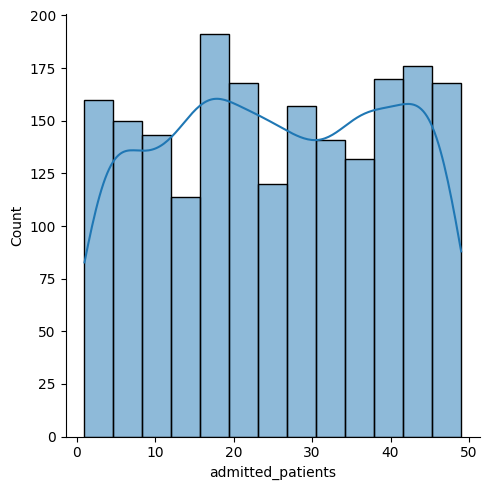

In [133]:
#check the distribution of the new column for its shape
sns.displot(hr_trans, x = 'admitted_patients', kde = True);

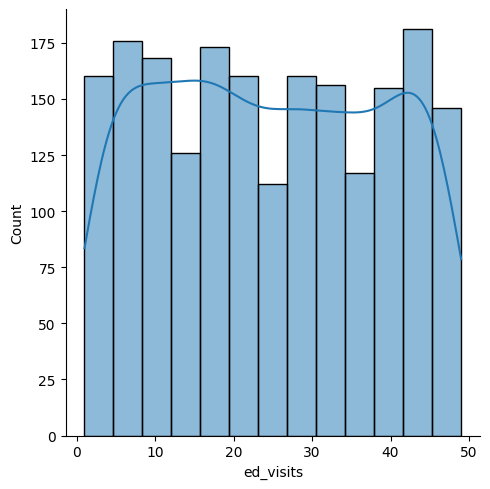

In [134]:
#check the distribution of the new column for its shape
sns.displot(hr_trans, x = 'ed_visits', kde = True);

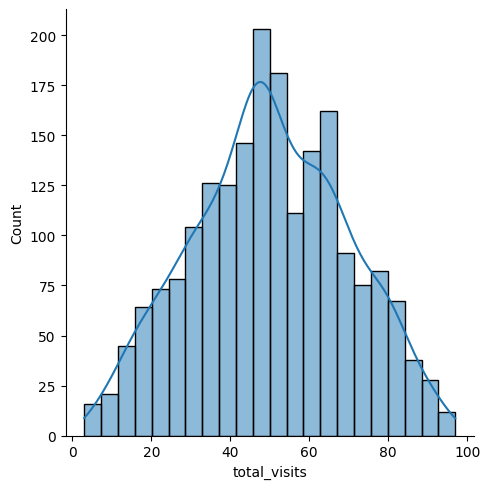

In [135]:
#check the distribution of the new column for its shape
sns.displot(hr_trans, x = 'total_visits', kde = True);

Total visits calculated from ed visits and admitted patients looks much normalized and well distributed. Let's see if we can derive total nurses from the nurse ratio and total visits. 

In [136]:
#Creating a new column which is the total nurses based upon the patients and the nurse patient ratio.
hr_trans['total_nurses'] = hr_trans['total_visits'] * hr_trans['nurse_patient_ratio']
#round up to the nearest value to represent reality, since we cannot have partial nurses and we need integer numbers.
hr_trans['total_nurses'].apply(np.ceil)

0       14.0
1       20.0
2       29.0
3        5.0
4       69.0
        ... 
1985    92.0
1986    12.0
1987     9.0
1988    72.0
1989    21.0
Name: total_nurses, Length: 1990, dtype: float64

In [137]:
hr_trans['total_nurses'].replace(to_replace = 0, value = hr_trans['total_nurses'].mean(), inplace=True)

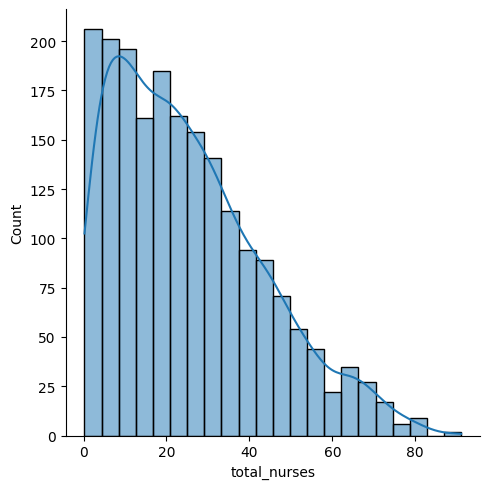

In [138]:
#check the distribution after we removed the 0s from the total nurses.
sns.displot(hr_trans, x = 'total_nurses', kde = True);

In [139]:
#applying a square root transform to the total nurses.
hr_trans['total_nurses_sqrt'] = np.sqrt(hr_trans['total_nurses'])

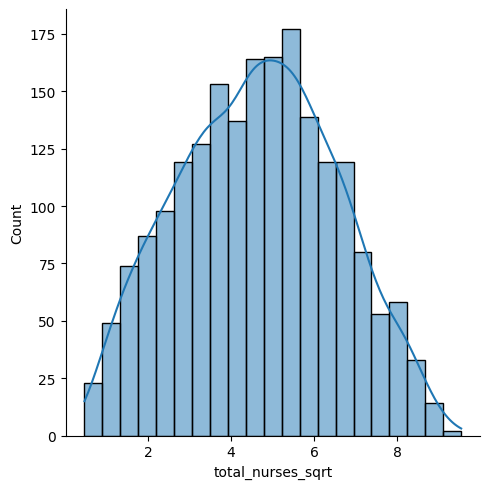

In [140]:
#Plot the Square Root transformation to this column.
sns.displot(hr_trans, x = 'total_nurses_sqrt', kde = True);

Total nurses caluclated had a skewed data set and sqrt of the same has given us more uniform and ditrbuted data. which would be better contribution to the model. 

In [141]:
hr_trans.head()

admitted_patients  nurse_patient_ratio  ...  total_nurses  total_nurses_sqrt
0                 23                 0.40  ...         14.00           3.741657
1                 22                 0.60  ...         19.80           4.449719
2                 47                 0.37  ...         28.86           5.372150
3                 20                 0.06  ...          4.02           2.004994
4                 33                 0.94  ...         68.62           8.283719

[5 rows x 11 columns]

In [142]:
col_names = ['admitted_patients', 'ed_visits','total_visits','total_nurses','total_nurses_sqrt']
features = hr_trans[col_names]

In [143]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

hr_trans[col_names] = scaler.fit_transform(features.values)
hr_trans.head(10)

admitted_patients  nurse_patient_ratio  ...  total_nurses  total_nurses_sqrt
0          -0.083333                 0.40  ...     -0.308135          -0.336632
1          -0.125000                 0.60  ...     -0.085572          -0.086246
2           0.916667                 0.37  ...      0.262087           0.239946
3          -0.208333                 0.06  ...     -0.691097          -0.950753
4           0.333333                 0.94  ...      1.787797           1.269538
5           0.875000                 0.09  ...     -0.676132          -0.917157
6           0.500000                 0.09  ...     -0.572525          -0.716845
7           0.583333                 0.84  ...      0.540675           0.465500
8          -0.750000                 0.49  ...     -0.582118          -0.733570
9           0.000000                 0.25  ...     -0.365695          -0.409521

[10 rows x 11 columns]

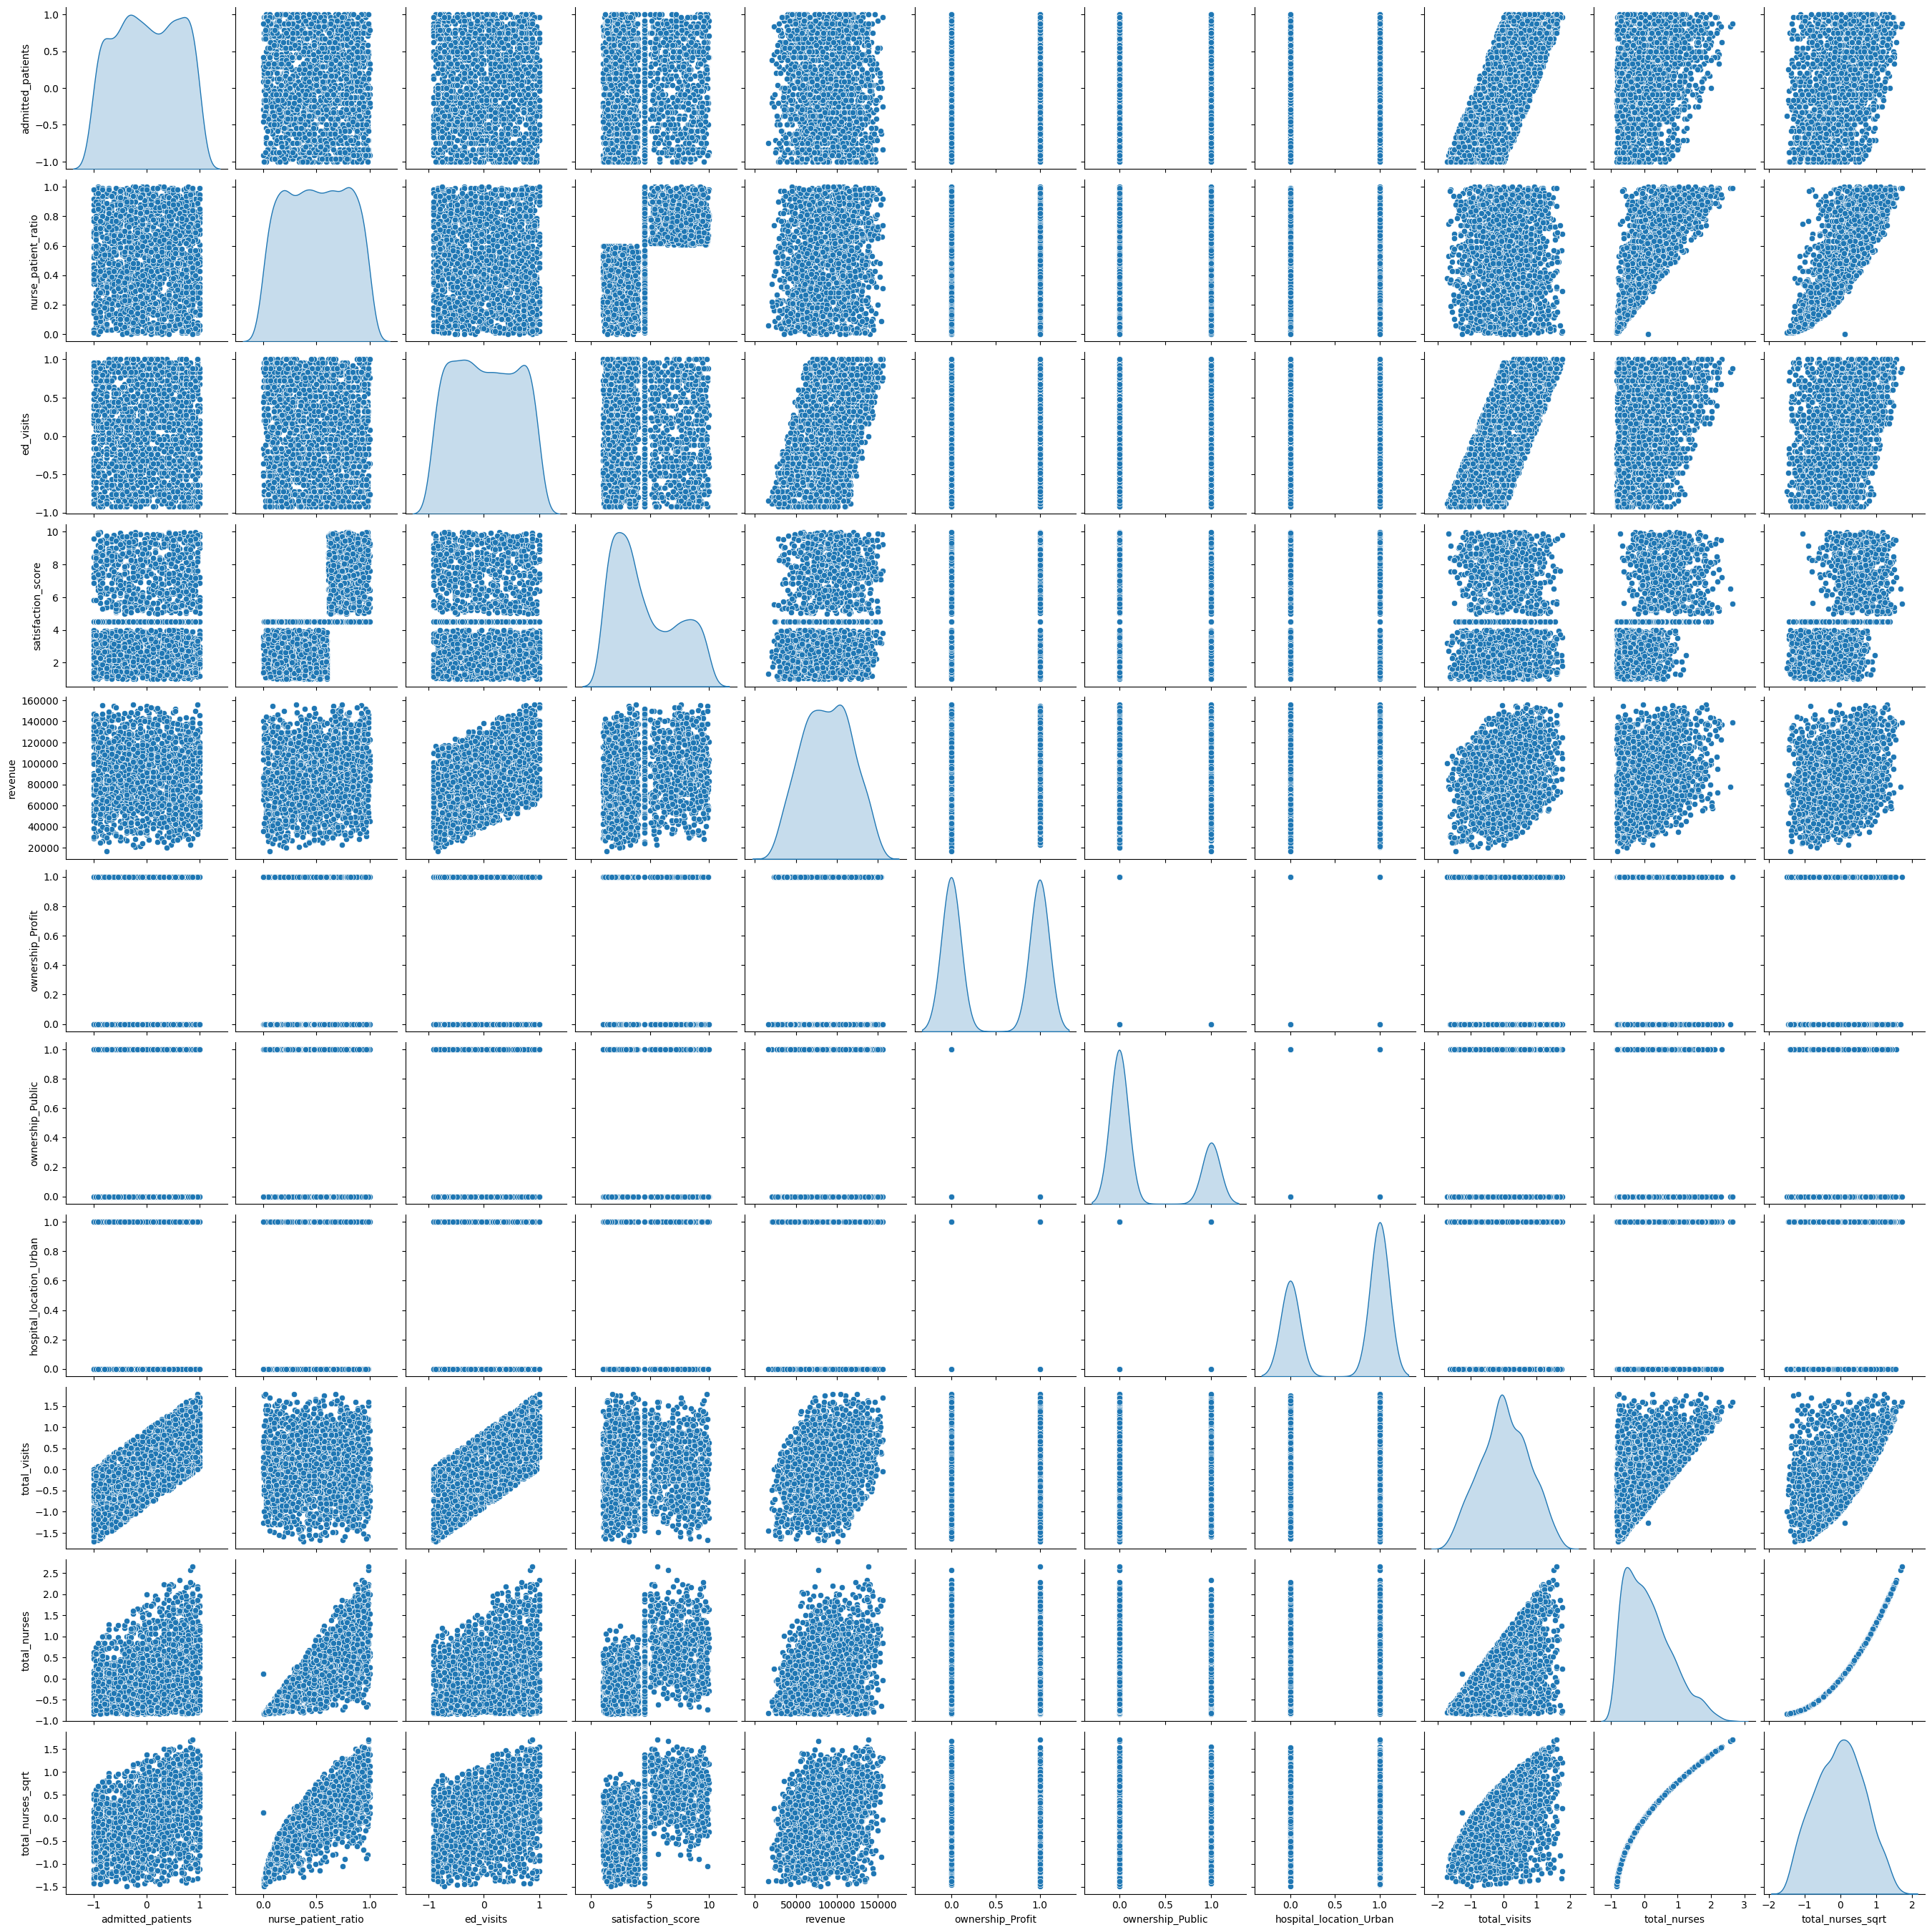

In [144]:
#displaying a pair plot to identify any independant variables and their relationship with the target variable.
sns.pairplot(data=hr_trans, diag_kind="kde")
plt.show();

In [145]:
X_trans = hr_trans.drop("revenue",axis=1) 
y_trans = hr_trans["revenue"]


In [146]:
X_train, X_test, y_train, y_test= train_test_split( X_trans,y_trans,test_size=0.25, random_state=42)

In [147]:
rfr = RandomForestRegressor()
# Set the number of trees
rfr.n_estimators = 50
# Add a maximum depth
rfr.max_depth = 5
# Set the random state
rfr.random_state = 1111
# Fit the model
rfr.fit(X_train, y_train)

print("Feature Importance:")
# Print how important each column is to the model
for i, item in enumerate(rfr.feature_importances_):
      # Use i and item to print out the feature importance of each column
    print("{0:s}: {1:.2f}".format(X_train.columns[i], item))

y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)

print("\nScores:")
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')
r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

Feature Importance:
admitted_patients: 0.04
nurse_patient_ratio: 0.06
ed_visits: 0.63
satisfaction_score: 0.15
ownership_Profit: 0.00
ownership_Public: 0.00
hospital_location_Urban: 0.01
total_visits: 0.04
total_nurses: 0.04
total_nurses_sqrt: 0.04

Scores:
MAE train: 21035.24
MAE test: 22223.67
R^2 train: 0.33
R^2 test: 0.26


In [148]:
X_trans_2 = hr_trans.drop(['revenue','ownership_Profit','ownership_Public','hospital_location_Urban','admitted_patients','ed_visits','nurse_patient_ratio','total_nurses'],axis=1) 
y_trans_2 = hr_trans["revenue"]

In [149]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split( X_trans_2,y_trans_2,test_size=0.25, random_state=42)

In [150]:
rfr = RandomForestRegressor()
# Set the number of trees
rfr.n_estimators = 50
# Add a maximum depth
rfr.max_depth = 5
# Set the random state
rfr.random_state = 1111
# Fit the model
rfr.fit(X_train_2, y_train_2)

print("Feature Importance:")
# Print how important each column is to the model
for i, item in enumerate(rfr.feature_importances_):
      # Use i and item to print out the feature importance of each column
    print("{0:s}: {1:.2f}".format(X_train_2.columns[i], item))

y_train_pred = rfr.predict(X_train_2)
y_test_pred = rfr.predict(X_test_2)

print("\nScores:")
mae_train = mean_absolute_error(y_train_2, y_train_pred)
mae_test = mean_absolute_error(y_test_2, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')
r2_train = r2_score(y_train_2, y_train_pred)
r2_test =r2_score(y_test_2, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

Feature Importance:
satisfaction_score: 0.27
total_visits: 0.48
total_nurses_sqrt: 0.25

Scores:
MAE train: 22258.83
MAE test: 23730.16
R^2 train: 0.21
R^2 test: 0.10


In [151]:
reg= LinearRegression()
reg.fit(X_train_2,y_train_2)


LinearRegression()

In [152]:
predict_train = reg.predict(X_train_2)
predict_test = reg.predict(X_test_2)

print("\nScores:")
mae_train = mean_absolute_error(y_train_2, predict_train)
mae_test = mean_absolute_error(y_test_2, predict_test)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')
r2_train = r2_score(y_train_2, predict_train)
r2_test =r2_score(y_test_2, predict_test)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')


Scores:
MAE train: 23864.40
MAE test: 23736.57
R^2 train: 0.10
R^2 test: 0.11


Looking at the stats feature scaling and feature transformation has not helped much with r2 and mae. This could b due to limited dataset and data concentrated around the few features making high impact.

LinearRegression() [0.16209924 0.21771279 0.14702928 0.28569531 0.13488728 0.23402273]
RandomForestRegressor() [0.12689925 0.11708956 0.02870165 0.22462671 0.05215985 0.15994424]


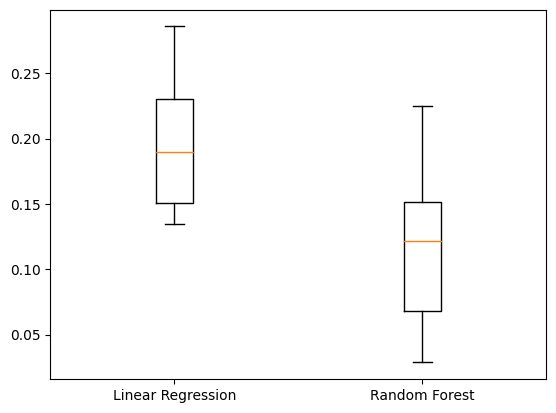

In [153]:
models = {"Linear Regression": LinearRegression(), "Random Forest": RandomForestRegressor()}
results = []

for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kf)
    print(model,cv_results)
    
    results.append(cv_results)

plt.boxplot(results, labels=models.keys())
plt.show()

In [154]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

[0.16209924 0.21771279 0.1518215  0.28569531 0.13475408 0.23402273]
[0.15488247 0.1254697  0.03847408 0.21499302 0.01817554 0.18870931]


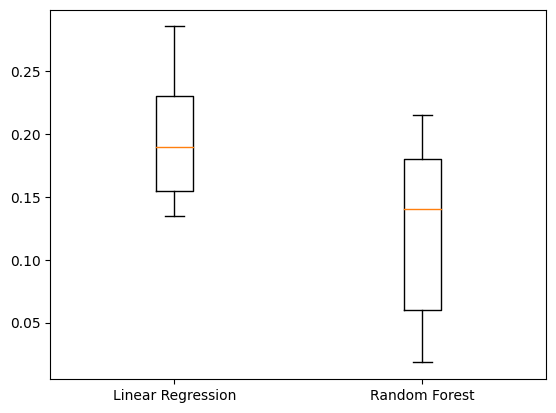

In [155]:
models = {"Linear Regression": LinearRegression(), "Random Forest": RandomForestRegressor()}
results = []

for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    print(cv_results)
    
    results.append(cv_results)

plt.boxplot(results, labels=models.keys())
plt.show()

In [156]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    print("{} Test Set Accuracy: {}".format(name,test_score))

Linear Regression Test Set Accuracy: 0.25953216019878933
Random Forest Test Set Accuracy: 0.18574172094153896


### Evaluate by Business Criteria
The Helth care provider wants to avoid prediction out of a range - within 10% of the actual revenue. Therefore, we would consider using percentage of predictions within 10% of the actual price as a KPI to compare the two models again. The higher the percentage, the better the model performs. 20.4% of the Linear regressor prediction is within 10% of the actual price, while the linear regression model only have 19.4%.

I would use Linear Regression model for revenue projections, as it spanned well over Random Forest model. would recommend revisiting the model parameters, scaling and tuning as we get more data avialable. 

In [157]:
X_test['Predicted_Revenue'] = np.round(predict_test,0)
X_test['Revenue'] = np.round(y_test,0)
lr_e = X_test
lr_e['Diff'] = (lr_e['Predicted_Revenue'] - lr_e['Revenue'])/lr_e['Revenue']
within_10pct = len([d for d in lr_e['Diff'] if abs(d) <= 0.1])
pct_lr = within_10pct/len(lr_e['Diff'])       
print(f'Percentage of predictions within +/- 10% range: {pct_lr}')

Percentage of predictions within +/- 10% range: 0.20481927710843373


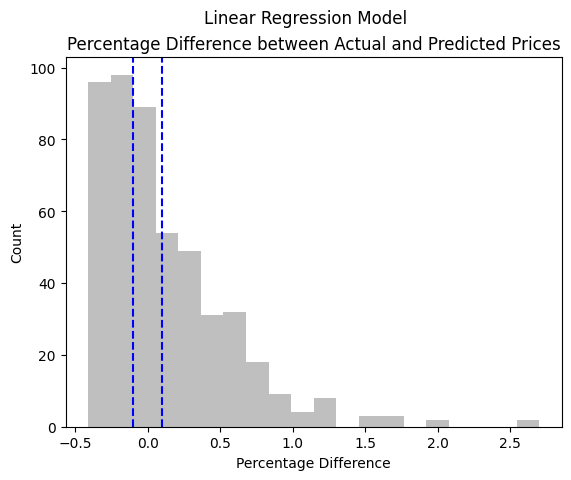

In [158]:
lr_e['Diff'] = (lr_e['Predicted_Revenue'] - lr_e['Revenue'])/lr_e['Revenue']
plt.hist(lr_e['Diff'], bins=20, color='gray',alpha=0.5)
plt.axvline(x=0.1, color='b', linestyle='--', label='+/- 10% range')
plt.axvline(x=-0.1, color='b', linestyle='--')
plt.title('Percentage Difference between Actual and Predicted Prices')
plt.suptitle('Linear Regression Model')
plt.xlabel('Percentage Difference')
plt.ylabel('Count');

In [159]:
X_test_2['Predicted_Revenue'] = np.round(y_test_pred,0)
X_test_2['Revenue'] = np.round(y_test_2,0)
rfr_e = X_test_2
rfr_e['Diff'] = (rfr_e['Predicted_Revenue'] - rfr_e['Revenue'])/rfr_e['Revenue']
within_10pct = len([d for d in rfr_e['Diff'] if abs(d) <= 0.1])
pct_rfr = within_10pct/len(rfr_e['Diff'])       
print(f'Percentage of predictions within +/- 10% range: {pct_rfr}')

Percentage of predictions within +/- 10% range: 0.19477911646586346


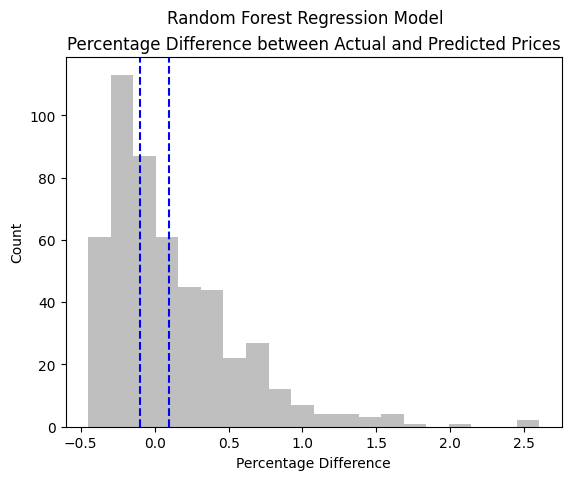

In [160]:
plt.hist(rfr_e['Diff'], bins=20,color='gray', alpha=0.5)
plt.axvline(x=0.1, color='b', linestyle='--', label='+/- 10% range')
plt.axvline(x=-0.1, color='b', linestyle='--')
plt.title('Percentage Difference between Actual and Predicted Prices')
plt.suptitle('Random Forest Regression Model')
plt.xlabel('Percentage Difference')
plt.ylabel('Count');

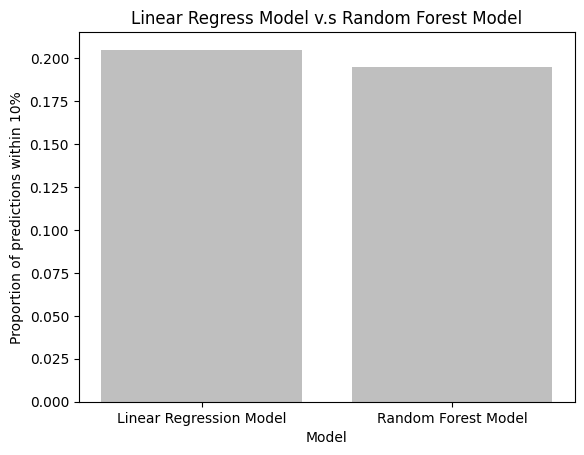

In [161]:
da = [pct_lr,pct_rfr]
labels =['Linear Regression Model','Random Forest Model']
plt.bar(labels, da,color='gray', alpha=0.5)


# Add labels to the chart
plt.title('Linear Regress Model v.s Random Forest Model')
plt.xlabel('Model')
plt.ylabel('Proportion of predictions within 10%')

# Show the chart
plt.show()

By implementing this model only 20% of predictions falls around 10% of the range. which is a low prediction rate. model needs to be tuned further with larger data set and evaluated. 

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation